In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
import os
from pathlib import Path
import pickle

home = str(Path.home())
data_path = os.path.join(home, "GA_generation", "Data", "GA_resampled.parquet")
perp_path = os.path.join(home, "GA_generation", "Data", "Normals_sampling.parquet")

import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import numpy as np
import pandas as pd

from traffic.core import Traffic, Flight
from traffic.data import airports
from traffic.drawing import countries
import traffic.core.geodesy as geo

t_GA_resampled = Traffic.from_file(data_path)
perpendiculars = pd.read_parquet(perp_path)
perpendiculars["angle"] = np.arctan(perpendiculars.m)

<ipython-input-3-41e8815f6da3>:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


<IPython.core.display.Javascript object>

In [5]:
# A = pd.read_pickle("Data/distributions_along_lines.pkl")
# B = pd.read_pickle("Data/generated_vines_and_sampling.pkl")
# C = pd.read_pickle("Data/generated_MVN_and_sampling.pkl")
# D = pd.read_pickle("Data/generated_MVN_and_WithoutSampling.pkl")
# E = pd.read_pickle("Data/generated_vines_and_WithoutSampling.pkl")

<IPython.core.display.Javascript object>

# Extract data

In [6]:
features = ["x", "y"]
X = np.stack(list(f.data[features].values.ravel() for f in t_GA_resampled))

<IPython.core.display.Javascript object>

n = 0


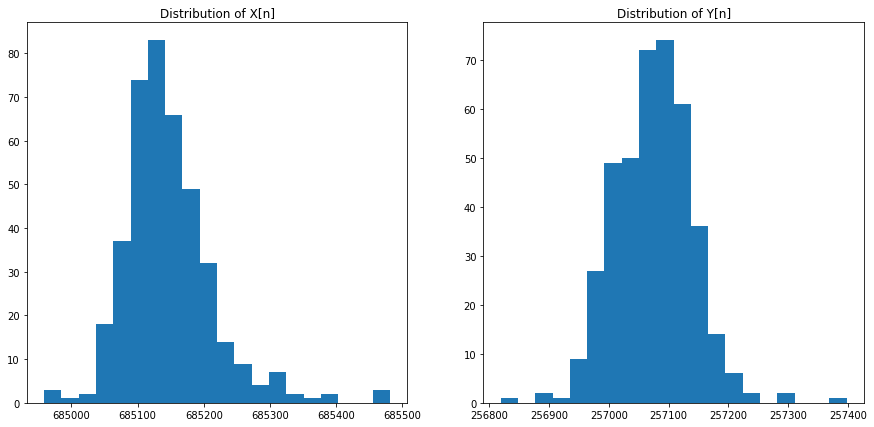

<IPython.core.display.Javascript object>

In [7]:
n = np.random.randint(30)
print("n =", n)
plt.figure(figsize=(15, 7))

plt.subplot(121)
plt.hist(X[:, ::2][:, n], bins=20)
plt.title("Distribution of X[n]")

plt.subplot(122)
plt.hist(X[:, 1::2][:, n], bins=20)
plt.title("Distribution of Y[n]")

plt.show()

## Plot de la distribution selon chaque droite

DISCLAIMER : 

Dans un même cluster, tous les points ne sont pas exactement sur la même ligne. Le fait de calculer Y à partir de X induit donc une erreur. Cette erreur est d'autant plus grande que la pente de la droite est élevée. Ainsi, pour calculer les nouvelles coordoonées dans le changement de repère, on va utiliser y réel. Après avoir estimé les copules, on repasse dans le repère X,Y. Comme on a considéré Y' = 0, on a fait la supposition que tous les points sont sur la même droite. Il faut faire attention donc ici, car à nouveau on peut avoir des surprises...

In [8]:
# On veut ploter la distribution des points selon chacune des lignes;
# Il faut donc trouver pour chaque ligne un point de référence, puis calculer la distance par rapport à ce point
# Pour la référence sur chaque ligne, on prend le ooint médian en X

X_x = X[:, ::2]
X_y = X[:, 1::2]
origins = np.zeros((len(perpendiculars), 2))

# ref_x = np.array([np.median(X_x, axis=0),] * X_x.shape[0])
# ref_y = np.array(
#     [perpendiculars.m.values * ref_x[0, :] + perpendiculars.p.values,] * X_x.shape[0]
# )

ref_x = np.array([X_x[97, :],] * X_x.shape[0])
ref_y = np.array(
    [perpendiculars.m.values * ref_x[0, :] + perpendiculars.p.values,] * X_x.shape[0]
)

# origins[:, 0] = ref_x[0, :]
# origins[:, 1] = ref_y[0, :]

origins[:, 0] = perpendiculars.x.values
origins[:, 1] = perpendiculars.y.values

# On projette les points d'une lignes (exprimés en x,y) sur cette ligne, pour n'avoir plus qu'un scalaire (x')
# x' = cos(alpha)*(x-x_ref) + sin(alpha)*(y-y_ref)

X_along_line = np.cos(perpendiculars.angle.values) * (X_x - ref_x) + np.sin(
    perpendiculars.angle.values
) * (X_y - ref_y)

X_along_line = pd.DataFrame(X_along_line)

<IPython.core.display.Javascript object>

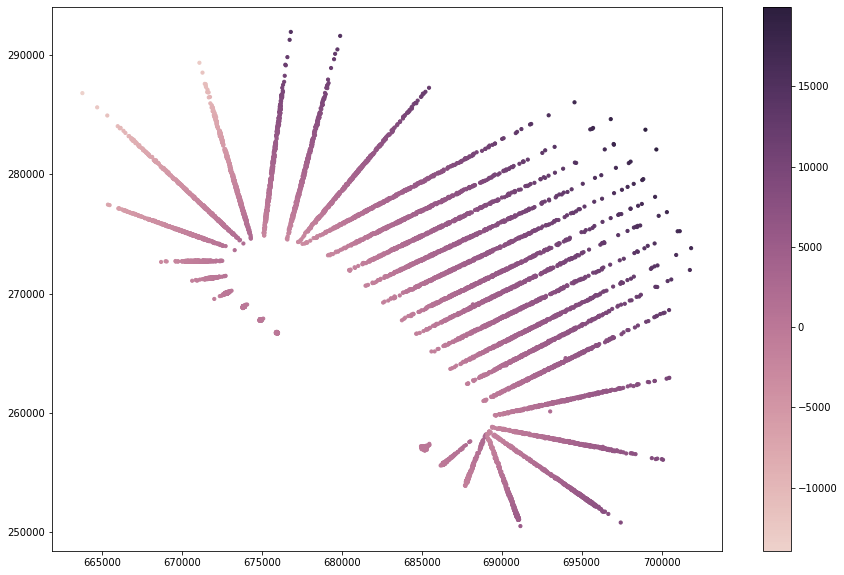

<IPython.core.display.Javascript object>

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

x, y, z = (
    np.array(X[:, ::2]).flatten(),
    np.array(X[:, 1::2]).flatten(),
    np.array(X_along_line).flatten(),
)
cmap = sns.cubehelix_palette(as_cmap=True)

f, ax = plt.subplots(figsize=(15, 10))
points = ax.scatter(x, y, c=z, s=10, cmap=cmap)
f.colorbar(points)
plt.show()

In [10]:
import altair as alt

n = np.random.randint(30)
print("n =", n)
A = (
    alt.Chart(X_along_line)
    .transform_density(str(n))
    .mark_area()
    .encode(x="value:Q", y="density:Q",)
)

A

n = 11


alt.Chart(...)

<IPython.core.display.Javascript object>

In [214]:
pd.DataFrame(origins, columns=["X", "Y"]).to_pickle(
    os.path.join(Path.home(), "GA_generation", "Data", "origins_sampling.pkl")
)

<IPython.core.display.Javascript object>

In [10]:
X_along_line.to_pickle(
    os.path.join(Path.home(), "GA_generation", "Data", "distributions_along_lines.pkl")
)

<IPython.core.display.Javascript object>

Cette méthode est en réalité très proche de l'utilisation d'un espace latent + sampling dans l'espace latent. Dans cette dernière (celle développée par Ardien), on utilise un autoencoder pour représenter les trajectoires dans un esapce latent plus adéquat que l'espace initial; on sample à l'intérieur (en utilisant les copules), puis on reconstruit la trajectoire avec le decoder. Notre méthode ici est très proche: A la place de fabriquer l'espace latent avec un réseau de neurones, on le fabrique à la main avec la méthode de sampling par rapport à une trajectoire de référence. Cela a l'avantage de faire moins "boite noire", et plus facilement modulable. Néanmoins, elle est adaptée pour des flux de trajectoires très régulières (comme des go arounds ou des approches sans holding patterns de l'article de Mayara). Si la trajectoire à sampler à une forme sensiblement différente de la trajectoire de référence, cela ne marche plus, et l'utilisation d'un espace latent plus complexe est indispensable.   

Cependant, quand on a peu de données comme ici avec les go-arounds, le DL peut-être peu approprié

# Real trajectories

In [11]:
# Signed curvature
def curvature(x, y):
    x_t = np.gradient(x)
    y_t = np.gradient(y)
    xx_t = np.gradient(x_t)
    yy_t = np.gradient(y_t)

    return (xx_t * y_t - x_t * yy_t) / (x_t * x_t + y_t * y_t) ** (3 / 2)

<IPython.core.display.Javascript object>

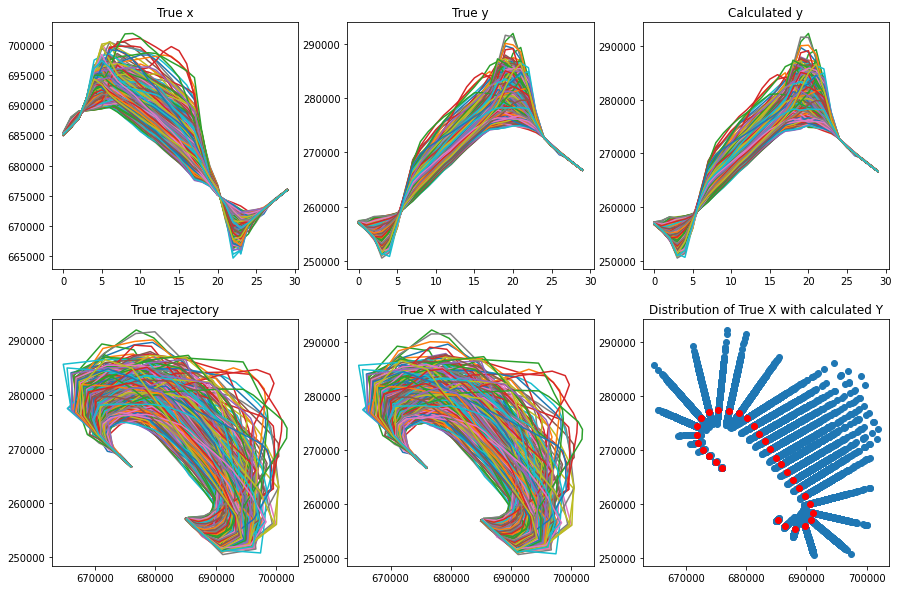

<IPython.core.display.Javascript object>

In [12]:
n_display = 400

plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.plot(X[:n_display, ::2].T)
plt.title("True x")

plt.subplot(232)
plt.plot(X[:n_display, 1::2].T)
plt.title("True y")

plt.subplot(233)
plt.plot((perpendiculars.m.values * X[:n_display, ::2] + perpendiculars.p.values).T)
plt.title("Calculated y")

plt.subplot(234)
plt.title("True trajectory")
plt.plot(
    X[:n_display, ::2].T, X[:n_display, 1::2].T,
)

plt.subplot(235)
plt.title("True X with calculated Y")
plt.plot(
    X[:n_display, ::2].T,
    (perpendiculars.m.values * X[:n_display, ::2] + perpendiculars.p.values).T,
)

plt.subplot(236)
plt.title("Distribution of True X with calculated Y")
plt.scatter(
    X[:n_display, ::2].T,
    (perpendiculars.m.values * X[:n_display, ::2] + perpendiculars.p.values).T,
)
plt.scatter(origins[:, 0], origins[:, 1], color="r")

plt.show()

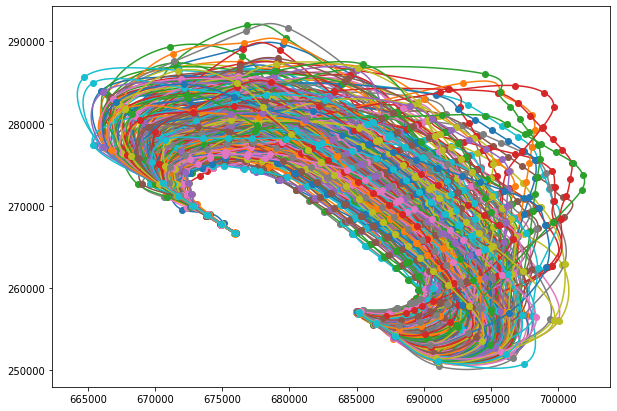

<IPython.core.display.Javascript object>

In [13]:
from scipy.interpolate import CubicSpline

# Pour l'interpolation :
# X est le temps (0,1,2,...)
# Y est la position (X(0),Y(0)), (X(1),Y(1))

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

fig, ax = plt.subplots(figsize=(10, 7))
x = list(range(0, 30))

spline_x = []
spline_y = []

for i in range(n_display):

    col = colors[i % len(colors)]

    #     y = np.vstack((X[:n_display, ::2][i], X[:n_display, 1::2][i])).T
    y = np.vstack((X[:, ::2][i], X[:, 1::2][i])).T
    cs = CubicSpline(x, y)
    xs = np.linspace(0, 29, 1000)
    ax.plot(y[:, 0], y[:, 1], "o", label="data", color=col)
    ax.plot(cs(xs)[:, 0], cs(xs)[:, 1], label="spline", color=col)
    spline_x.append(cs(xs)[:, 0])
    spline_y.append(cs(xs)[:, 1])

plt.show()

In [141]:
def calc_tangent(x, y):
    dx_dt = np.gradient(x)
    dy_dt = np.gradient(y)
    velocity = np.array([[dx_dt[i], dy_dt[i]] for i in range(dx_dt.size)])
    ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt)
    tangent = np.array([1 / ds_dt] * 2).transpose() * velocity
    return tangent


def distances_to_line(X0, Y0, m, k):
    dist_horiz = np.abs(k + m * X0 - Y0) / np.sqrt(1 + m ** 2)
    return dist_horiz

#A peu de choses près, on retrouve la courbure
def linear_approx_deviation(x, y):
    d = []
    for i in range(1, len(x) - 1):
        m = (y[i + 1] - y[i - 1]) / (x[i + 1] - x[i - 1])
        k = y[i + 1] - m * x[i + 1]
        d.append(distances_to_line(x[i], y[i], m, k))
    return d

<IPython.core.display.Javascript object>

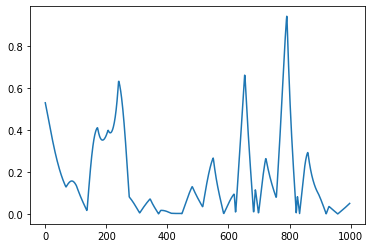

<IPython.core.display.Javascript object>

In [146]:
plt.plot(linear_approx_deviation(spline_x[i], spline_y[i]))

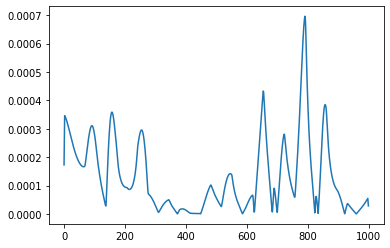

<IPython.core.display.Javascript object>

In [148]:
plt.plot(np.abs(curvature(spline_x[i], spline_y[i])))

199


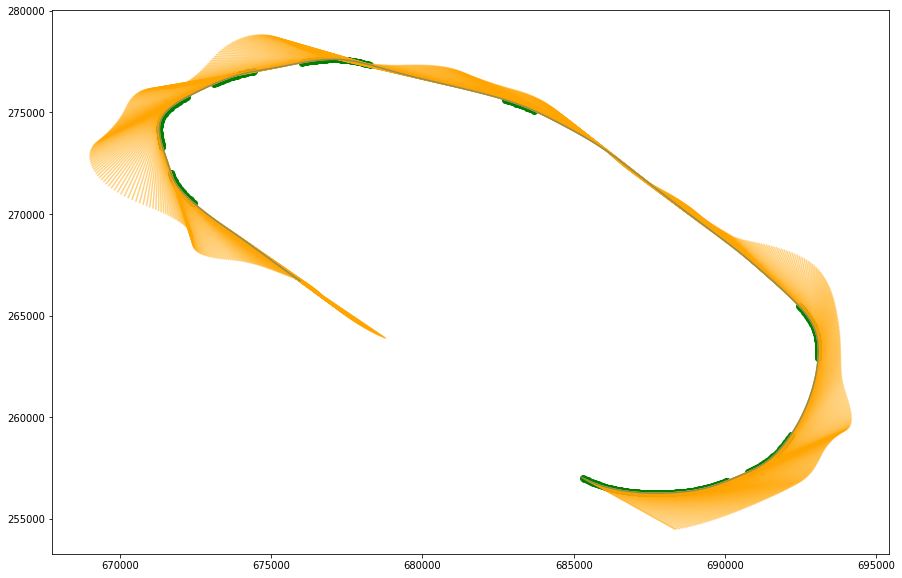

<IPython.core.display.Javascript object>

In [152]:
i = np.random.randint(400)
print(i)
plt.figure(figsize=(15, 10))

# x = X[:, ::2][i]
# y = X[:, 1::2][i]
x = spline_x[i]
y = spline_y[i]
tan = calc_tangent(x, y)
dot = []
for i in range(len(tan) - 1):
    dot.append(np.dot(tan[i], tan[i + 1]))
idx = np.where(np.array(dot) < 0.99)[0] + 1
plt.scatter(x[idx], y[idx], color="r")
for i, l in enumerate(tan):
    xs = [x[i], x[i] + 4000 * l[0]]
    ys = [y[i], y[i] + 4000 * l[1]]
    plt.plot(xs, ys, color="orange", alpha=0.5)

plt.plot(x, y, alpha=0.5)
curv = np.abs(curvature(x, y))
indexes = np.where(curv > 0.00012)[0] + 1
plt.scatter(x[indexes], y[indexes], color="g")

plt.show()

199
Mean curvature variation : 6.5346823380258205e-06
Number of turns : 10


<ipython-input-133-aaa14a08cf84>:6: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(curvature(spline_x[i], spline_y[i])))


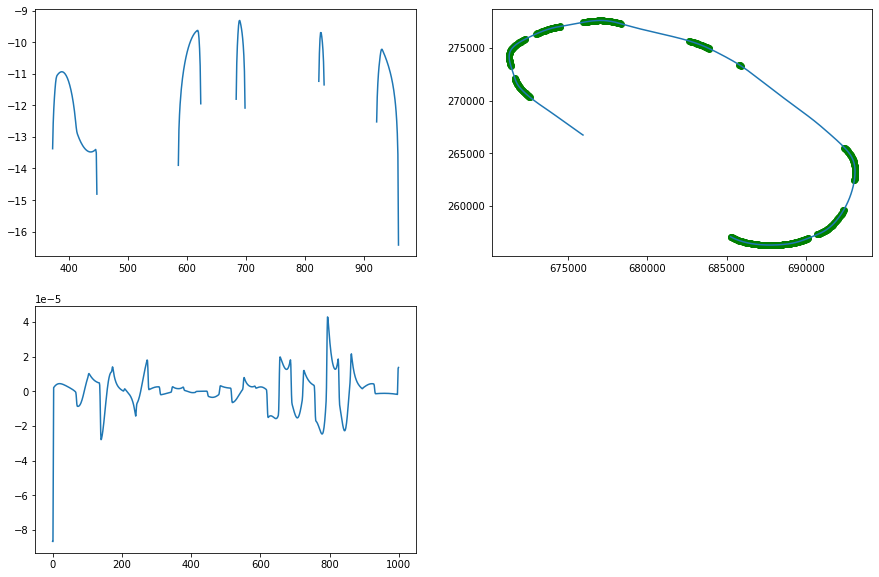

<IPython.core.display.Javascript object>

In [133]:
i = np.random.randint(400)
print(i)
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(curvature(spline_x[i], spline_y[i]))
indexes1 = np.where(curvature(spline_x[i], spline_y[i]) > 0.00010)
indexes2 = np.where(curvature(spline_x[i], spline_y[i]) < -0.00010)
plt.scatter(indexes1, curvature(spline_x[i], spline_y[i])[indexes1], color="r")
plt.scatter(indexes2, curvature(spline_x[i], spline_y[i])[indexes2], color="g")
plt.hlines(0.00010, 0, 1000, color="r")
plt.hlines(-0.00010, 0, 1000, color="r")

plt.subplot(222)
plt.plot(spline_x[i], spline_y[i])
plt.scatter(spline_x[i][indexes1], spline_y[i][indexes1], color="r")
plt.scatter(spline_x[i][indexes2], spline_y[i][indexes2], color="g")

plt.subplot(223)
curv_var = np.gradient(curvature(spline_x[i], spline_y[i]))
plt.plot(curv_var)

print("Mean curvature variation :", np.abs(curv_var).mean())
print(
    "Number of turns :",
    np.sum(np.diff(indexes1[0], 1) != 1) + 1 + np.sum(np.diff(indexes2[0], 1) != 1) + 1,
)

plt.show()

In [34]:
variations = []
nb_turns = []
for i in range(n_display):
    indexes1 = np.where(curvature(spline_x[i], spline_y[i]) > 0.00010)
    indexes2 = np.where(curvature(spline_x[i], spline_y[i]) < -0.00010)

    variations.append(np.gradient(curvature(spline_x[i], spline_y[i])))
    nb_turns.append(
        np.sum(np.diff(indexes1[0], 1) != 1)
        + 1
        + np.sum(np.diff(indexes2[0], 1) != 1)
        + 1
    )

print("Variation moyenne : ", np.abs(variations).mean())
print("Mean number of turns : ", np.array(nb_turns).mean())

Variation moyenne :  2.0511403517016148e-05
Mean number of turns :  7.815


<IPython.core.display.Javascript object>

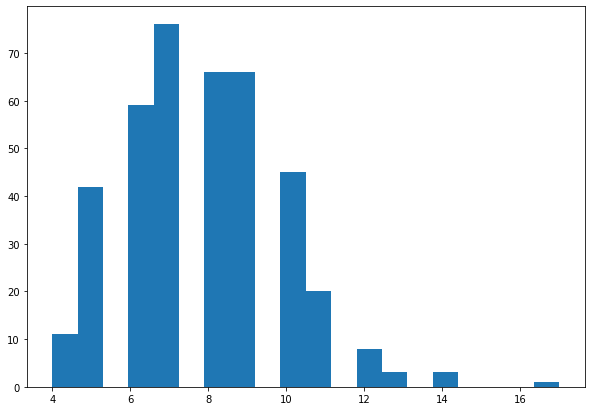

<IPython.core.display.Javascript object>

In [35]:
plt.figure(figsize=(10, 7))
plt.hist(nb_turns, bins=20)
plt.show()

# Copule statistique

- Aurait-on pas besoin de plus de données ... ? Ou alors au contraire enlever encore plus des trajectoires "bizarres"
- On pourrait essayer aussi les réseaux bayésiens
- Sinon, processus gaussiens (chose qui est possible pour moi, et pas dans la méthode d'Adrien avec les autoencoders)

- Pour le Bayesian network : https://webia.lip6.fr/~phw//aGrUM/docs/last/notebooks/
Nous il faudrait faire un réseau de la forme 1->2->3->4.....

In [18]:
import openturns as ot
from sklearn import preprocessing

# scale = preprocessing.MinMaxScaler().fit(X_along_line)
# scale = preprocessing.StandardScaler().fit(X_along_line)
# X_scaled = scale.transform(X_along_line)

to_fit = np.array(X_along_line)
# to_fit = np.array(X_scaled)

sample = ot.Sample(to_fit)
sample

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=407 dimension=30 data=[[-25.0459,-157.978,-1144.5,...,-26.3673,-1.61612,-6.41327],[18.0369,-124.674,-1152.95,...,-20.9859,-6.89148,-6.34654],[-35.4312,-180.29,-1060.57,...,-18.3517,-6.52025,2.66049],...,[18.0074,-63.3895,-1188.92,...,-75.5451,-20.9711,33.5143],[-29.7145,837.314,2269.39,...,4.23543,-22.9935,3.70501],[-19.3925,-259.247,-1212.84,...,-97.5273,10.1936,41.446]]

<IPython.core.display.Javascript object>

In [19]:
# Si on veut des copules de vine
# Sans spécifier la strcutre de la vine

import pyvinecopulib as pv

u = pv.to_pseudo_obs(sample)  # CDR empirique (c'est mieux)
# u = np.array(copula_sample)  # CDR estimée

# Pour les séries temporelles, les Dvines semblent adaptées
# dvine = pv.DVineStructure(list(range(sample.getDimension())))
# controls = pv.FitControlsVinecop()
cop = pv.Vinecop(data=u)

# Si on ne spécifie rien, le modèle apprend seul la structure Dvine
cop.structure

n_sim = 1000
u_sim = cop.simulate(n_sim)
x_sim = np.asarray([np.quantile(sample[:, i], u_sim[:, i]) for i in range(0, 30)]).T

<IPython.core.display.Javascript object>

In [45]:
# En spécifiant la structure de la vine

# # matrice pour une D vine

# matD = np.zeros((40, 40))
# matD[:39, 0] = list(range(2, 41))

# for i in range(1, 40):
#     matD[:39, i] = matD[:39, i - 1] + 1

# matD[matD > 40] = 0

# for i in range(0, 40):
#     matD[i, 39 - i] = 40 - i

# # Ce qui est long, c'est fitter les marginales
# controls = pv.FitControlsVinecop()
# cop2 = pv.Vinecop(data=u, matrix=matD, controls=controls)

# n_sim = 1000
# u_sim = cop2.simulate(n_sim)
# x_sim = np.asarray([np.quantile(sample[:, i], u_sim[:, i]) for i in range(0, 40)]).T

<IPython.core.display.Javascript object>

In [24]:
pd.DataFrame(x_sim).to_pickle(
    os.path.join(
        Path.home(), "GA_generation", "Data", "generated_vines_and_sampling.pkl"
    )
)

<IPython.core.display.Javascript object>

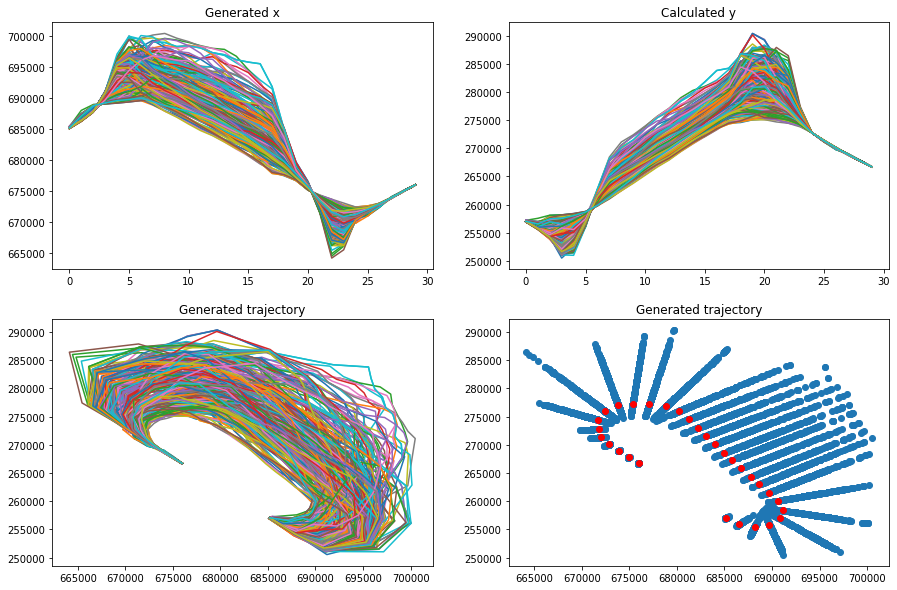

<IPython.core.display.Javascript object>

In [20]:
reference_change = True
n_gen = 400
rand = np.random.randint(0, n_sim, n_gen)

#### Si on a modélisé les écarts à une référence sur chaque ligne ####
if reference_change:
    #     gen_x = scale.inverse_transform(estimated_distribution.getSample(n_gen))
    #     gen_x = estimated_distribution.getSample(n_gen)
    #     gen_x = scale.inverse_transform(x_sim[rand])
    gen_x = x_sim[rand]
    gen_x = gen_x * np.array([np.cos(perpendiculars.angle.values),] * n_gen) + np.array(
        [origins[:, 0],] * n_gen
    )

#### Si on a modélisé directement X ####
else:
    gen_x = scale.inverse_transform(estimated_distribution.getSample(n_gen))

calc_y = perpendiculars.m.values * gen_x + perpendiculars.p.values


plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(gen_x.T)
plt.title("Generated x")

plt.subplot(222)
plt.plot(calc_y.T)
plt.title("Calculated y")

plt.subplot(223)
plt.title("Generated trajectory")
plt.plot(
    gen_x.T, calc_y.T,
)

plt.subplot(224)
plt.title("Generated trajectory")
plt.scatter(
    gen_x.T, calc_y.T,
)
plt.scatter(origins[:, 0], origins[:, 1], color="r")
plt.show()

En règle générale, les copules vines marchent tout de même bien mieux. Utiliser un scaler sur les données ne semble pas changer fondamentalement les choses. 

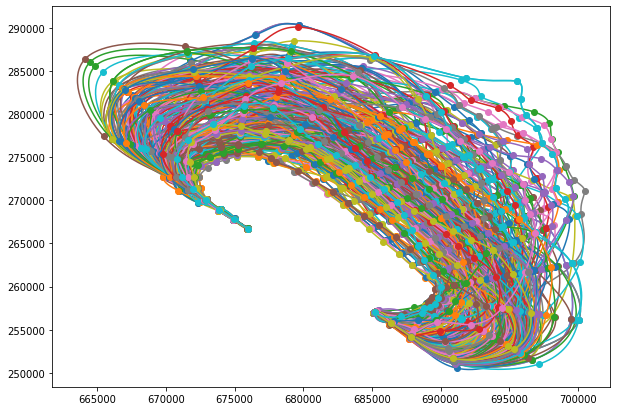

<IPython.core.display.Javascript object>

In [21]:
from scipy.interpolate import CubicSpline

# Pour l'interpolation :
# X est le temps (0,1,2,...)
# Y est la position (X(0),Y(0)), (X(1),Y(1))

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

fig, ax = plt.subplots(figsize=(10, 7))
x = list(range(0, 30))

spline_x = []
spline_y = []

for i in range(n_gen):
    col = colors[i % len(colors)]

    y = np.vstack((gen_x[i], calc_y[i])).T
    cs = CubicSpline(x, y)
    xs = np.linspace(0, 29, 1000)
    ax.plot(y[:, 0], y[:, 1], "o", label="data", color=col)
    ax.plot(cs(xs)[:, 0], cs(xs)[:, 1], label="spline", color=col)
    spline_x.append(cs(xs)[:, 0])
    spline_y.append(cs(xs)[:, 1])

plt.show()

Mean curvature variation : 6.766411772758756e-06
Number of turns : 10


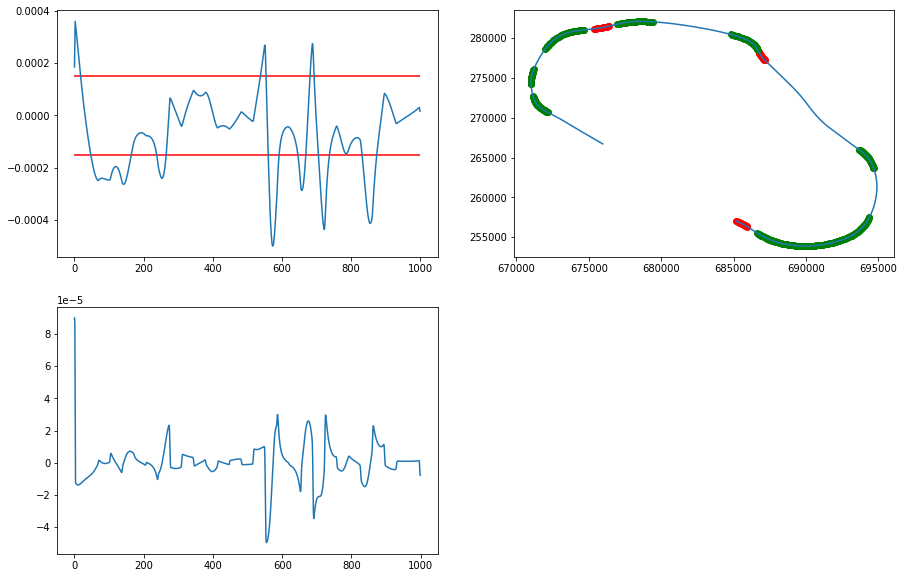

<IPython.core.display.Javascript object>

In [25]:
i = 200

plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(curvature(spline_x[i], spline_y[i]))
indexes1 = np.where(curvature(spline_x[i], spline_y[i]) > 0.00010)
indexes2 = np.where(curvature(spline_x[i], spline_y[i]) < -0.00010)
plt.hlines(0.00015, 0, 1000, color="r")
plt.hlines(-0.00015, 0, 1000, color="r")

plt.subplot(222)
plt.plot(spline_x[i], spline_y[i])
plt.scatter(spline_x[i][indexes1], spline_y[i][indexes1], color="r")
plt.scatter(spline_x[i][indexes2], spline_y[i][indexes2], color="g")

plt.subplot(223)
curv_var = np.gradient(curvature(spline_x[i], spline_y[i]))
plt.plot(curv_var)

print("Mean curvature variation :", np.abs(curv_var).mean())
print(
    "Number of turns :",
    np.sum(np.diff(indexes1[0], 1) != 1) + 1 + np.sum(np.diff(indexes2[0], 1) != 1) + 1,
)

plt.show()

In [26]:
variations = []
nb_turns = []
for i in range(n_gen):
    indexes1 = np.where(curvature(spline_x[i], spline_y[i]) > 0.00010)
    indexes2 = np.where(curvature(spline_x[i], spline_y[i]) < -0.00010)

    variations.append(np.gradient(curvature(spline_x[i], spline_y[i])))
    nb_turns.append(
        np.sum(np.diff(indexes1[0], 1) != 1)
        + 1
        + np.sum(np.diff(indexes2[0], 1) != 1)
        + 1
    )

print("Variation moyenne : ", np.abs(variations).mean())
print("Mean number of turns : ", np.array(nb_turns).mean())

Variation moyenne :  2.129979349403314e-05
Mean number of turns :  12.7875


<IPython.core.display.Javascript object>

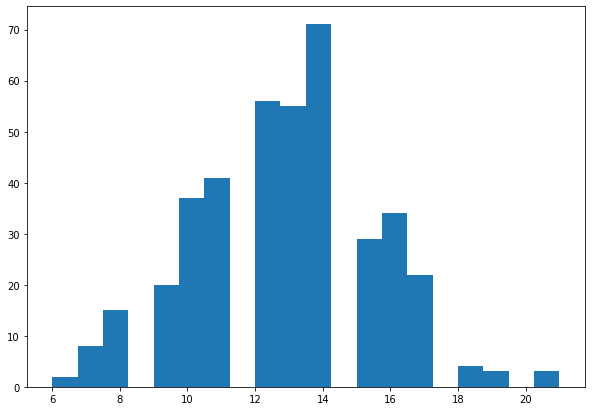

<IPython.core.display.Javascript object>

In [30]:
plt.figure(figsize=(10, 7))
plt.hist(nb_turns, bins=20)
plt.show()

Comment améliorer l'estimation :
- Avoir plus de données ? 
- Réduire le nombre de variables ?
- Améliorer l'algo d'estimation des copules lui même (avec bayesian network par exemple) ?

Ici on compare l'apport des copules sur la normale multivariée sur le même set de données. On peut aussi comparer l'apport du resampling. Comme groundbase, on peut simuler avec une normale multivariée le vecteur des x et des y pour un resampling naif. D'une part on montre l'apport de la méthode de resampling sur la qualité de l'estimation, à méthode stat constante, puis l'apport d'une meilleure méthode statistique à features constantes. Il est très fort probable que le resampling lui même apporte plus que les copules; mais il faut montre que part rapport à la méthode de Mayara, c'est mieux ! 

Il faudrait réussir à trouver une métrique quantitative pour comparer les méthodes: Par exemple, réussir à qualifier la smoothness des trrajectoires réelles, et de regarder quelle méthode se rapproche le plus. On peut regarder la courbure (Ou la torsion ???) des trajectoires générées par rapport à celle des trajectoires réelles. Idéalement, on devrait avoir beeaucoup de lignes droites, donc à savoir de longues parties où la courbure doit être nulle. De plus, elle ne doit pas être trop élevée 

Evidemment, plus on augment le nombre de points par trajectoire, plus les différences entre les méthodes s'accroissent

# Multivariate Normal + Sampling

In [42]:
from sklearn.covariance import LedoitWolf
import openturns as ot
from sklearn import preprocessing

# scale = preprocessing.MinMaxScaler().fit(X_along_line)
scale = preprocessing.StandardScaler().fit(X_along_line)
X_scaled = scale.transform(X_along_line)

n_gen = 400

cov = LedoitWolf().fit(X_along_line)
# cov = LedoitWolf().fit(X_scaled)
gen_x = np.random.multivariate_normal(cov.location_, cov.covariance_, n_gen)
# gen_x = scale.inverse_transform(gen_x)

<IPython.core.display.Javascript object>

In [43]:
pd.DataFrame(gen_x).to_pickle(
    os.path.join(Path.home(), "GA_generation", "Data", "generated_MVN_and_sampling.pkl")
)

<IPython.core.display.Javascript object>

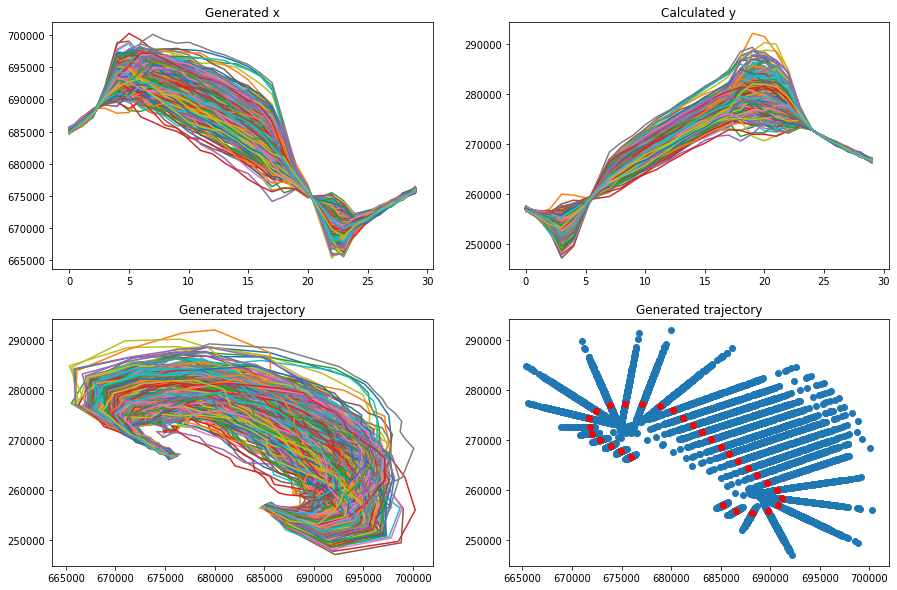

<IPython.core.display.Javascript object>

In [44]:
gen_x = gen_x * np.array([np.cos(perpendiculars.angle.values),] * n_gen) + np.array(
    [origins[:, 0],] * n_gen
)
calc_y = perpendiculars.m.values * gen_x + perpendiculars.p.values


plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(gen_x.T)
plt.title("Generated x")

plt.subplot(222)
plt.plot(calc_y.T)
plt.title("Calculated y")

plt.subplot(223)
plt.title("Generated trajectory")
plt.plot(
    gen_x.T, calc_y.T,
)

plt.subplot(224)
plt.title("Generated trajectory")
plt.scatter(
    gen_x.T, calc_y.T,
)
plt.scatter(origins[:, 0], origins[:, 1], color="r")
plt.show()

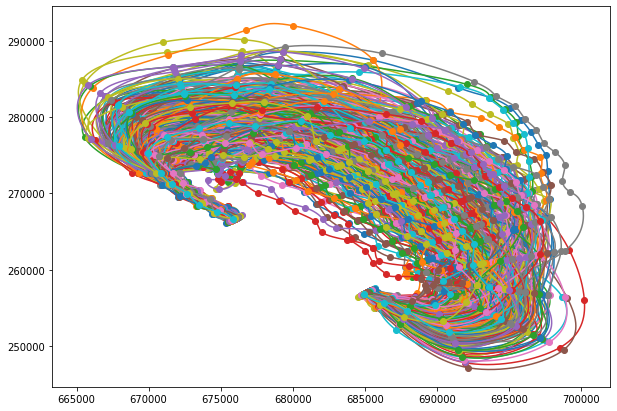

<IPython.core.display.Javascript object>

In [45]:
from scipy.interpolate import CubicSpline

# Pour l'interpolation :
# X est le temps (0,1,2,...)
# Y est la position (X(0),Y(0)), (X(1),Y(1))

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

fig, ax = plt.subplots(figsize=(10, 7))
x = list(range(0, 30))
spline_x = []
spline_y = []

for i in range(n_gen):

    col = colors[i % len(colors)]

    y = np.vstack((gen_x[i], calc_y[i])).T
    cs = CubicSpline(x, y)
    xs = np.linspace(0, 29, 1000)
    ax.plot(y[:, 0], y[:, 1], "o", label="data", color=col)
    ax.plot(cs(xs)[:, 0], cs(xs)[:, 1], label="spline", color=col)
    spline_x.append(cs(xs)[:, 0])
    spline_y.append(cs(xs)[:, 1])

plt.show()

Mean curvature variation : 1.941814289920453e-05
Number of turns : 18


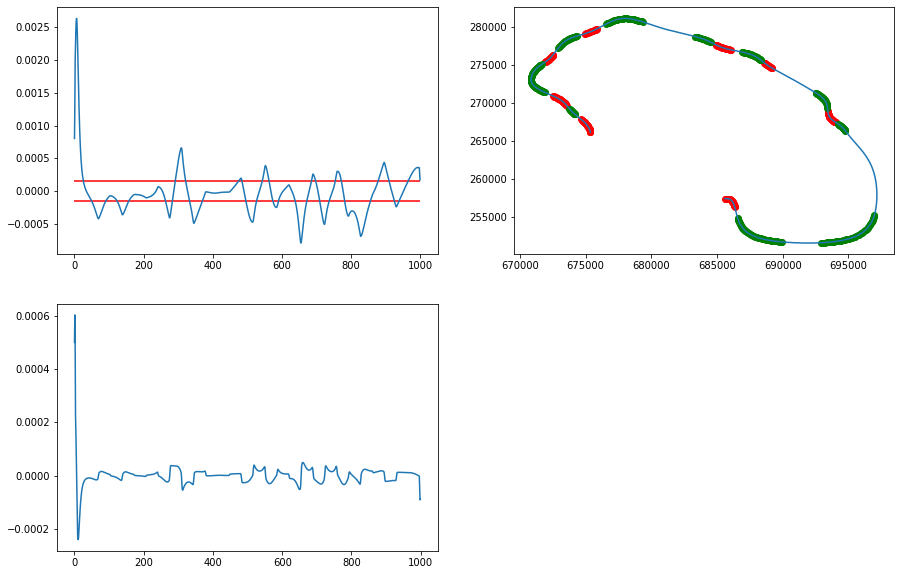

<IPython.core.display.Javascript object>

In [46]:
i = 200

plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(curvature(spline_x[i], spline_y[i]))
indexes1 = np.where(curvature(spline_x[i], spline_y[i]) > 0.00010)
indexes2 = np.where(curvature(spline_x[i], spline_y[i]) < -0.00010)
plt.hlines(0.00015, 0, 1000, color="r")
plt.hlines(-0.00015, 0, 1000, color="r")

plt.subplot(222)
plt.plot(spline_x[i], spline_y[i])
plt.scatter(spline_x[i][indexes1], spline_y[i][indexes1], color="r")
plt.scatter(spline_x[i][indexes2], spline_y[i][indexes2], color="g")

plt.subplot(223)
curv_var = np.gradient(curvature(spline_x[i], spline_y[i]))
plt.plot(curv_var)

print("Mean curvature variation :", np.abs(curv_var).mean())
print(
    "Number of turns :",
    np.sum(np.diff(indexes1[0], 1) != 1) + 1 + np.sum(np.diff(indexes2[0], 1) != 1) + 1,
)

plt.show()

In [47]:
variations = []
nb_turns = []
for i in range(n_gen):
    indexes1 = np.where(curvature(spline_x[i], spline_y[i]) > 0.00010)
    indexes2 = np.where(curvature(spline_x[i], spline_y[i]) < -0.00010)

    variations.append(np.gradient(curvature(spline_x[i], spline_y[i])))
    nb_turns.append(
        np.sum(np.diff(indexes1[0], 1) != 1)
        + 1
        + np.sum(np.diff(indexes2[0], 1) != 1)
        + 1
    )

print("Variation moyenne : ", np.abs(variations).mean())
print("Mean number of turns : ", np.array(nb_turns).mean())

Variation moyenne :  3.070122811271224e-05
Mean number of turns :  18.3725


<IPython.core.display.Javascript object>

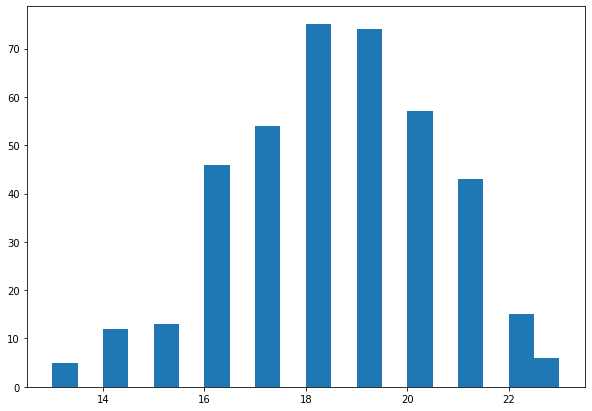

<IPython.core.display.Javascript object>

In [48]:
plt.figure(figsize=(10, 7))
plt.hist(nb_turns, bins=20)
plt.show()

Lorsqu'on fait le sampling, que ce soit avec les MVN ou les copules, normaliser les données en entrée ne semble pas changer significativement les résultats

Lorsqu'on plot un grand nombre de trajectoires, la shape du flux généré est sensiblemen bien meilleure dans le cas des copules que des MVN !!!

# MVN without sampling

Pour Without sampling, on a le choix de regarder comment on a rriver à modéliser avec le sampling selon les lignes, mais sans faire le changement de repère (avec la variable X), ou alors carrément ne pas prendre en compte le resampling (X_raw). Avec la première méthode, on remarque que le fitting se fait un peu moins bien, mais semble toujours assez raisonnable. Si on ne prend pas en compte le resampling, on retombe sur la méthode de Mayara

Globalement, si on garde le sampling mais qu'on ne fait pas de référence change, la performance est comparable ( a la limite un peu moins bonne). En revanche, le referance change nous permet de diminuer de moitié le nombre de variables à apprendre; donc le temps d'exécution: Et ca c'est cool !

In [49]:
import pyproj

swiss = pyproj.Proj(init="EPSG:21781")

ga_raw = (
    Traffic.from_file("Data/Go_Arounds_clean.parquet")
    .resample(30)
    .compute_xy(projection=swiss)
    .eval(desc="")
)
features = ["x", "y"]
X_raw = np.stack(list(f.data[features].values.ravel() for f in ga_raw))

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/pyproj/crs/crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


  0%|          | 0/407 [00:00<?, ?it/s]

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(tz_naive=lambda d: d.timestamp.astype("datetime64[ns]"))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic/core/flight.py:1255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj

<IPython.core.display.Javascript object>

In [50]:
from sklearn.covariance import LedoitWolf
import openturns as ot
from sklearn import preprocessing

# scale = preprocessing.MinMaxScaler().fit(X_along_line)
scale = preprocessing.StandardScaler().fit(X_raw)
X_scaled = scale.transform(X_raw)

n_gen = 400

cov = LedoitWolf().fit(X_raw)
# cov = LedoitWolf().fit(X_scaled)
gen = np.random.multivariate_normal(cov.location_, cov.covariance_, n_gen)
# gen = scale.inverse_transform(gen)

<IPython.core.display.Javascript object>

In [51]:
pd.DataFrame(gen).to_pickle(
    os.path.join(
        Path.home(), "GA_generation", "Data", "generated_MVN_and_WithoutSampling.pkl"
    )
)

<IPython.core.display.Javascript object>

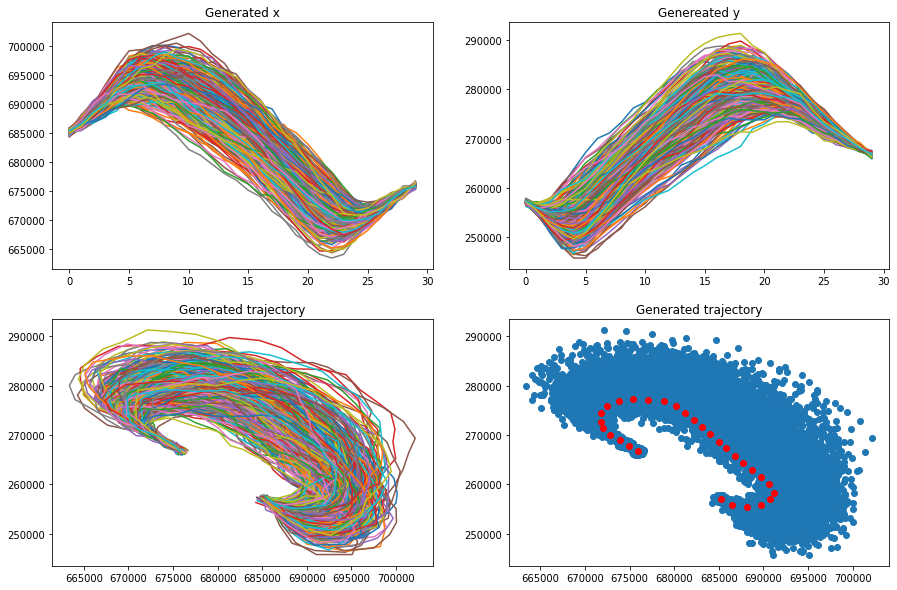

<IPython.core.display.Javascript object>

In [52]:
gen_x = gen[:, ::2]
gen_y = gen[:, 1::2]


plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(gen_x.T)
plt.title("Generated x")

plt.subplot(222)
plt.plot(gen_y.T)
plt.title("Genereated y")

plt.subplot(223)
plt.title("Generated trajectory")
plt.plot(
    gen_x.T, gen_y.T,
)

plt.subplot(224)
plt.title("Generated trajectory")
plt.scatter(
    gen_x.T, gen_y.T,
)
plt.scatter(origins[:, 0], origins[:, 1], color="r")
plt.show()

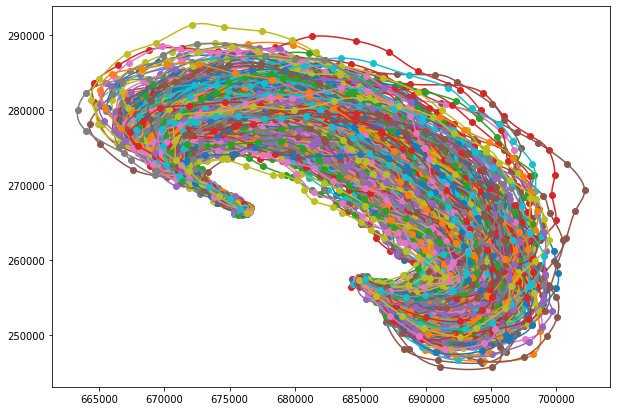

<IPython.core.display.Javascript object>

In [53]:
from scipy.interpolate import CubicSpline

# Pour l'interpolation :
# X est le temps (0,1,2,...)
# Y est la position (X(0),Y(0)), (X(1),Y(1))

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

fig, ax = plt.subplots(figsize=(10, 7))
x = list(range(0, 30))
spline_x = []
spline_y = []

for i in range(n_gen):

    col = colors[i % len(colors)]

    y = np.vstack((gen_x[i], gen_y[i])).T
    cs = CubicSpline(x, y)
    xs = np.linspace(0, 29, 1000)
    ax.plot(y[:, 0], y[:, 1], "o", label="data", color=col)
    ax.plot(cs(xs)[:, 0], cs(xs)[:, 1], label="spline", color=col)
    spline_x.append(cs(xs)[:, 0])
    spline_y.append(cs(xs)[:, 1])

plt.show()

Mean curvature variation : 1.8635297685535314e-05
Number of turns : 18


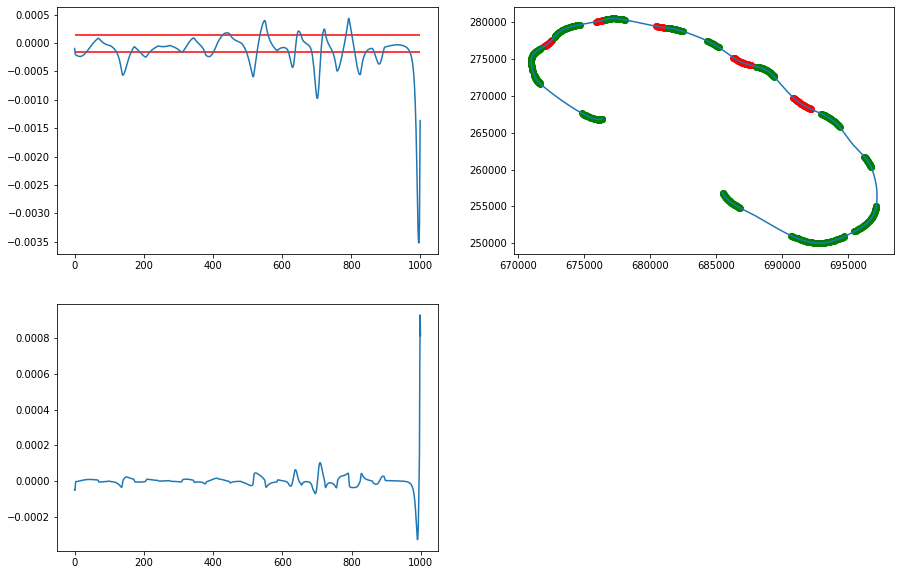

<IPython.core.display.Javascript object>

In [54]:
i = 180

plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(curvature(spline_x[i], spline_y[i]))
indexes1 = np.where(curvature(spline_x[i], spline_y[i]) > 0.00010)
indexes2 = np.where(curvature(spline_x[i], spline_y[i]) < -0.00010)
plt.hlines(0.00015, 0, 1000, color="r")
plt.hlines(-0.00015, 0, 1000, color="r")

plt.subplot(222)
plt.plot(spline_x[i], spline_y[i])
plt.scatter(spline_x[i][indexes1], spline_y[i][indexes1], color="r")
plt.scatter(spline_x[i][indexes2], spline_y[i][indexes2], color="g")

plt.subplot(223)
curv_var = np.gradient(curvature(spline_x[i], spline_y[i]))
plt.plot(curv_var)

print("Mean curvature variation :", np.abs(curv_var).mean())
print(
    "Number of turns :",
    np.sum(np.diff(indexes1[0], 1) != 1) + 1 + np.sum(np.diff(indexes2[0], 1) != 1) + 1,
)

plt.show()

In [55]:
variations = []
nb_turns = []
for i in range(n_gen):
    indexes1 = np.where(curvature(spline_x[i], spline_y[i]) > 0.00010)
    indexes2 = np.where(curvature(spline_x[i], spline_y[i]) < -0.00010)

    variations.append(np.gradient(curvature(spline_x[i], spline_y[i])))
    nb_turns.append(
        np.sum(np.diff(indexes1[0], 1) != 1)
        + 1
        + np.sum(np.diff(indexes2[0], 1) != 1)
        + 1
    )

print("Variation moyenne : ", np.abs(variations).mean())
print("Mean number of turns : ", np.array(nb_turns).mean())

Variation moyenne :  4.767308599323089e-05
Mean number of turns :  18.11


<IPython.core.display.Javascript object>

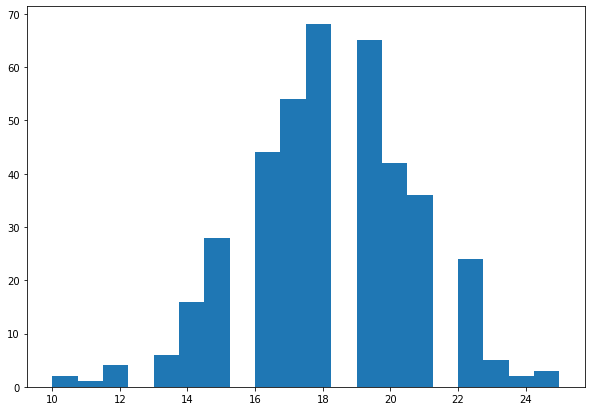

<IPython.core.display.Javascript object>

In [56]:
plt.figure(figsize=(10, 7))
plt.hist(nb_turns, bins=20)
plt.show()

# Copulas without sampling

In [57]:
import pyvinecopulib as pv

u = pv.to_pseudo_obs(X_raw)

cop = pv.Vinecop(data=u)

n_sim = 400
u_sim = cop.simulate(n_sim)
x_sim = np.asarray([np.quantile(X_raw[:, i], u_sim[:, i]) for i in range(0, 30 * 2)]).T

<IPython.core.display.Javascript object>

In [58]:
pd.DataFrame(x_sim).to_pickle(
    os.path.join(
        Path.home(), "GA_generation", "Data", "generated_vines_and_WithoutSampling.pkl"
    )
)

<IPython.core.display.Javascript object>

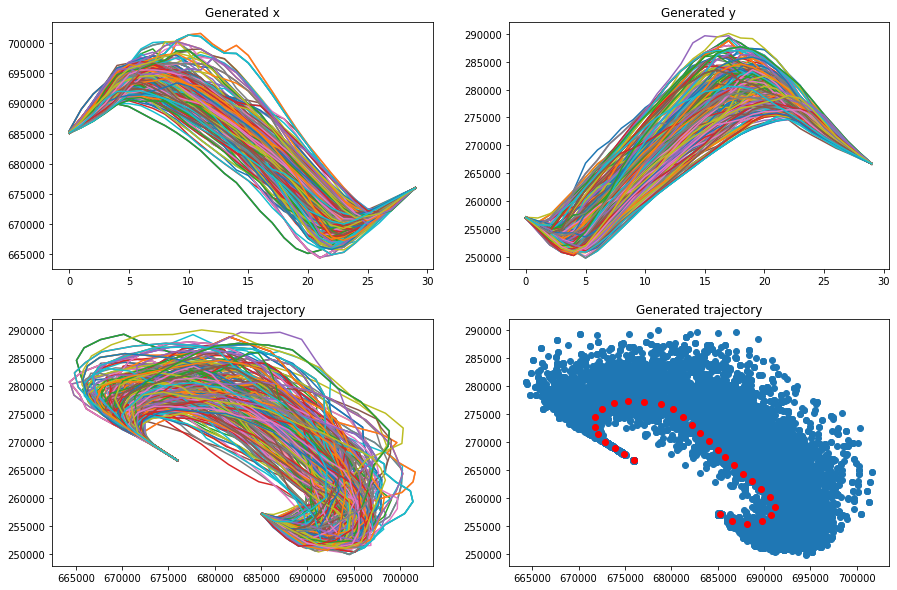

<IPython.core.display.Javascript object>

In [59]:
n_gen = 400
rand = np.random.randint(0, n_sim, n_gen)

gen = x_sim[rand]
gen_x = gen[:, ::2]
gen_y = gen[:, 1::2]


plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(gen_x.T)
plt.title("Generated x")

plt.subplot(222)
plt.plot(gen_y.T)
plt.title("Generated y")

plt.subplot(223)
plt.title("Generated trajectory")
plt.plot(
    gen_x.T, gen_y.T,
)

plt.subplot(224)
plt.title("Generated trajectory")
plt.scatter(
    gen_x.T, gen_y.T,
)
plt.scatter(origins[:, 0], origins[:, 1], color="r")
plt.show()

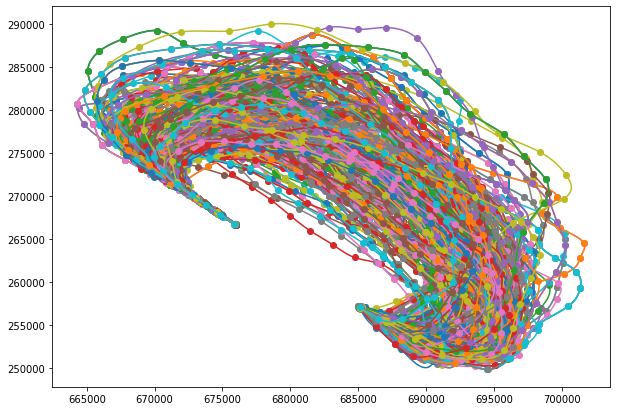

<IPython.core.display.Javascript object>

In [91]:
from scipy.interpolate import CubicSpline

# Pour l'interpolation :
# X est le temps (0,1,2,...)
# Y est la position (X(0),Y(0)), (X(1),Y(1))

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

fig, ax = plt.subplots(figsize=(10, 7))
x = list(range(0, 30))

spline_x = []
spline_y = []

for i in range(n_gen):

    col = colors[i % len(colors)]

    y = np.vstack((gen_x[i], gen_y[i])).T
    cs = CubicSpline(x, y)
    xs = np.linspace(0, 29, 1000)
    ax.plot(y[:, 0], y[:, 1], "o", label="data", color=col)
    ax.plot(cs(xs)[:, 0], cs(xs)[:, 1], label="spline", color=col)
    spline_x.append(cs(xs)[:, 0])
    spline_y.append(cs(xs)[:, 1])

plt.show()

In [77]:
variations = []
nb_turns = []
for i in range(n_gen):
    indexes1 = np.where(curvature(spline_x[i], spline_y[i]) > 0.00010)
    indexes2 = np.where(curvature(spline_x[i], spline_y[i]) < -0.00010)

    variations.append(np.gradient(curvature(spline_x[i], spline_y[i])))
    nb_turns.append(
        np.sum(np.diff(indexes1[0], 1) != 1)
        + 1
        + np.sum(np.diff(indexes2[0], 1) != 1)
        + 1
    )

print("Variation moyenne : ", np.abs(variations).mean())
print("Mean number of turns : ", np.array(nb_turns).mean())

Variation moyenne :  1.4445510487789406e-05
Mean number of turns :  11.175


<IPython.core.display.Javascript object>

Mean curvature variation : 4.062319987222431e-06
Number of turns : 7


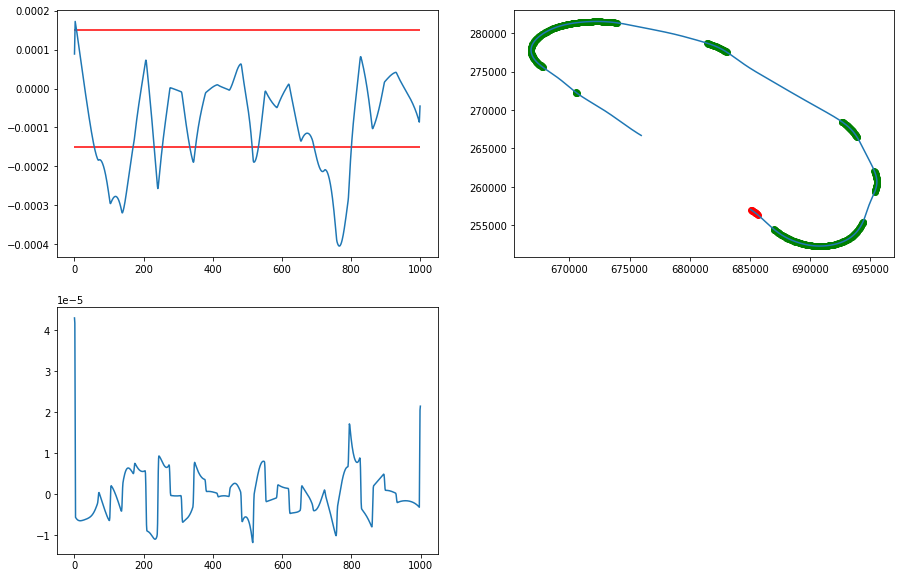

<IPython.core.display.Javascript object>

In [65]:
i = 150

plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(curvature(spline_x[i], spline_y[i]))
indexes1 = np.where(curvature(spline_x[i], spline_y[i]) > 0.00010)
indexes2 = np.where(curvature(spline_x[i], spline_y[i]) < -0.00010)
plt.hlines(0.00015, 0, 1000, color="r")
plt.hlines(-0.00015, 0, 1000, color="r")

plt.subplot(222)
plt.plot(spline_x[i], spline_y[i])
plt.scatter(spline_x[i][indexes1], spline_y[i][indexes1], color="r")
plt.scatter(spline_x[i][indexes2], spline_y[i][indexes2], color="g")

plt.subplot(223)
curv_var = np.gradient(curvature(spline_x[i], spline_y[i]))
plt.plot(curv_var)

print("Mean curvature variation :", np.abs(curv_var).mean())
print(
    "Number of turns :",
    np.sum(np.diff(indexes1[0], 1) != 1) + 1 + np.sum(np.diff(indexes2[0], 1) != 1) + 1,
)

plt.show()

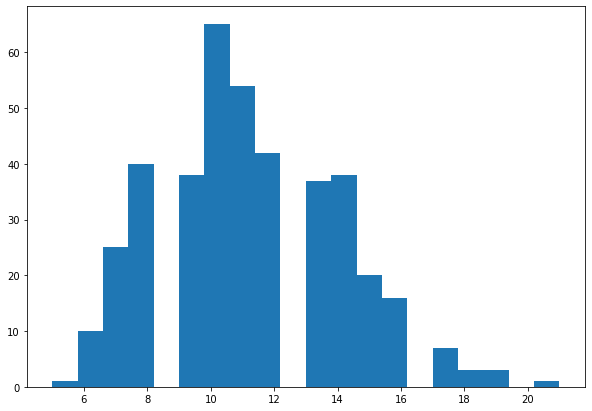

<IPython.core.display.Javascript object>

In [63]:
plt.figure(figsize=(10, 7))
plt.hist(nb_turns, bins=20)
plt.show()

Idées pour les métriques : 
- La courbure moyenne d'un flux (boof)
- La variation de courbure moyenne d'un flux (pourquoi pas, mais pas parfait : Ne fait pas la différence entre les vaguelettes et les gros virages)
- Le nombre de virages moyens d'un flux 
- Le nombre de virages moyens d'un flux, pondéré par la courbure
- Taille de la plus longue ligne droite / ligne droite moyenne